In [1]:
### Map retinotopic responses to visual stimuli
### script to analyze 2p responses to driting gratings (showSpatialMappingBars.m)
### input: suite2p output
### JSY, 03/02/2025

JSY041 250228
Frame rate: 10.05 Hz
Off time: 0.5 s, On time: 2.0 s
Repeats: 20, Num cells: 1347, X positions: 15, Y positions: 15
Off frames: 5, On frames: 20
Size of resp_x_avg: (1347, 15)
Size of resp_y_avg: (1347, 15)


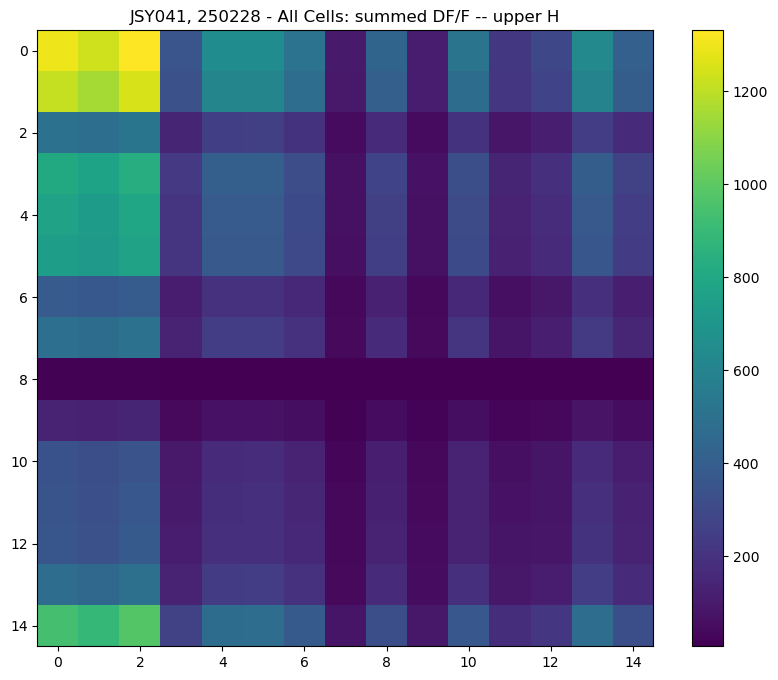

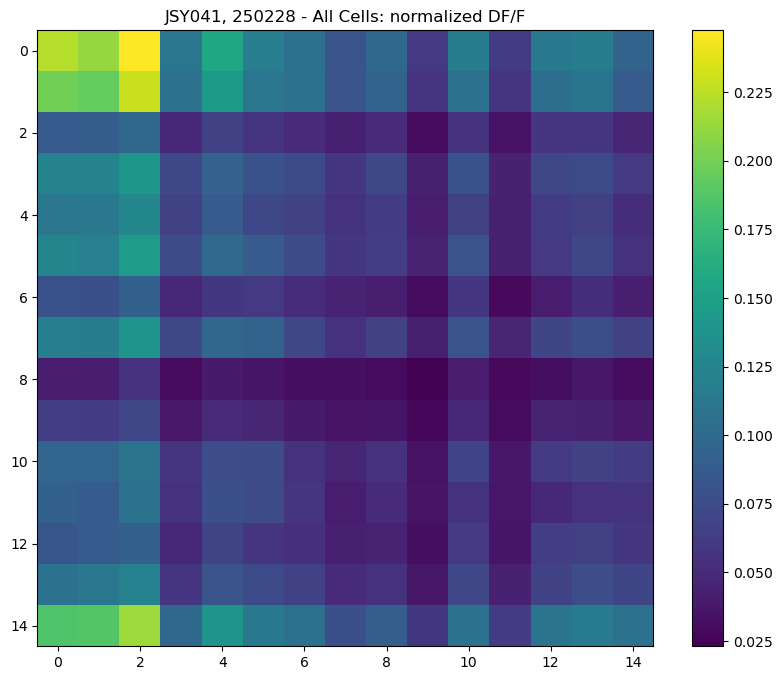

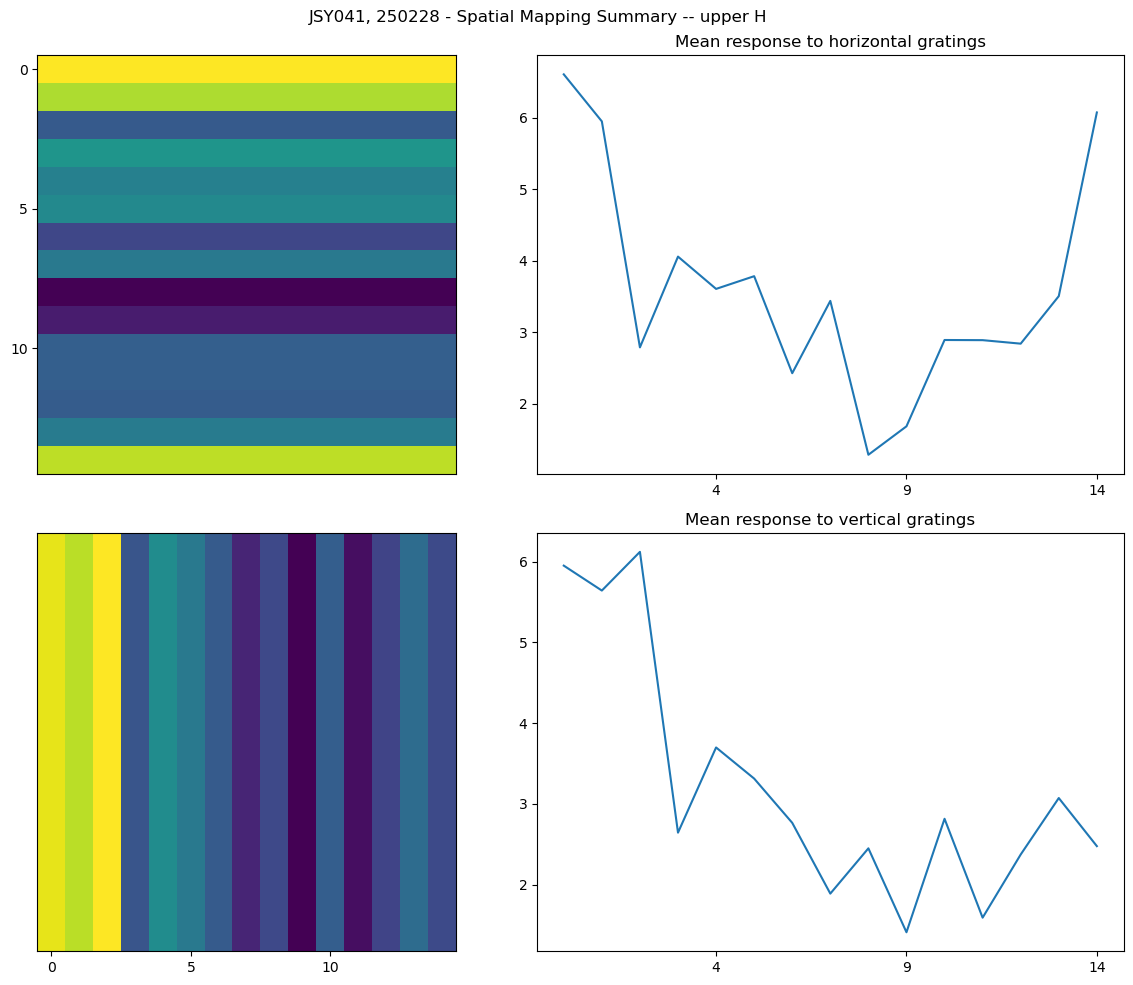

In [ ]:
import os
import numpy as np
import scipy.io as sio
from helper import TwoP, read_xml
import matplotlib.pyplot as plt

# animal id and date
animal_id = "JSY041"
date = 250228
print(animal_id, date)

# File path to data
filepath = r'D:\V1_SpatialModulation\2p\250304_JSY_JSY041_V1ExpressionCheck_DifferentHeight\TSeries-03042025-1455_UpperH-001'
twoP_filename = "TSeries-03042025-1455_UpperH-001"
stim_filepath = r''

# Initialize dictionaries to store raw data
twoP_data = {}

# Load twoP data
raw_twop_data = TwoP(filepath, twoP_filename)
stim_data = sio.loadmat(stim_filepath)

raw_twop_data.find_files()
twop_dict = raw_twop_data.calc_dFF()

twoP_data['sps'] = twop_dict['spikes_per_sec'].copy()
twoP_data['dFF'] = twop_dict['norm_dFF'].copy()

numFrames = np.size(twoP_data['sps'], 1)

# Load XML data for timing information
xml_path = os.path.join(filepath, f"{twoP_filename}.xml")
xml_dict = read_xml(xml_path)
t0 = xml_dict["t0"]
abs_time = xml_dict["abs_time"]
rel_time = xml_dict["rel_time"]
framerate = 1/rel_time[1]
print(f"Frame rate: {framerate:.2f} Hz")

# Parameters - extract exactly as they're stored in MATLAB struct
# MATLAB structs are loaded as nested arrays in scipy.io.loadmat
off_time = float(stim_data['Stimdata']['offTime'][0][0][0][0])
on_time = float(stim_data['Stimdata']['onTime'][0][0][0][0])
print(f"Off time: {off_time} s, On time: {on_time} s")

# Calculate additional parameters
repeats = int(stim_data['Stimdata']['numRep'][0][0][0][0])
num_cells = np.size(twoP_data['dFF'], 0)
num_x = int(stim_data['Stimdata']['num_x'][0][0][0][0])
num_y = int(stim_data['Stimdata']['num_y'][0][0][0][0])
print(f"Repeats: {repeats}, Num cells: {num_cells}, X positions: {num_x}, Y positions: {num_y}")

pres_time = off_time + on_time
rep_time = pres_time * (num_x + num_y)
off_frames = round(off_time * framerate)
on_frames = round(on_time * framerate)
print(f"Off frames: {off_frames}, On frames: {on_frames}")

# Extract position lists
x_pos_list = stim_data['Stimdata']['x_pos_list'][0][0]
y_pos_list = stim_data['Stimdata']['y_pos_list'][0][0]

# Initialize response arrays
off_resp = np.zeros((num_cells, off_frames))
on_resp = np.zeros((num_cells, on_frames))

# Initialize arrays to match MATLAB dimensions
resp_x = np.zeros((num_cells, num_x, repeats))
resp_y = np.zeros((num_cells, num_y, repeats))

# Process each repetition
for rep in range(repeats):
    for pos_x in range(num_x):
        curr_pos = int(x_pos_list[rep, pos_x])
        curr_frame = round((rep*rep_time + pos_x*pres_time)*framerate)
        # Extract off and on responses
        for f in range(off_frames):
            off_resp[:, f] = twoP_data['dFF'][:, curr_frame+f]
        for f in range(on_frames):
            on_resp[:, f] = twoP_data['dFF'][:, curr_frame+off_frames+f]
        resp_x[:, curr_pos-1, rep] = np.mean(on_resp, axis=1) - np.mean(off_resp, axis=1)
    
    for pos_y in range(num_y):
        curr_pos = int(y_pos_list[rep, pos_y])
        curr_frame = round((rep*rep_time + (pos_y+num_x)*pres_time)*framerate)
        # Extract off and on responses
        for f in range(off_frames):
            off_resp[:, f] = twoP_data['dFF'][:, curr_frame+f]
        for f in range(on_frames):
            on_resp[:, f] = twoP_data['dFF'][:, curr_frame+off_frames+f]
        resp_y[:, curr_pos-1, rep] = np.mean(on_resp, axis=1) - np.mean(off_resp, axis=1)
    
    # print(f"Repeat {rep+1}/{repeats} processed")

# Average responses across repetitions
resp_x_avg = np.mean(resp_x, axis=2)
resp_y_avg = np.mean(resp_y, axis=2)

# Rectify negative response values to 0.01
for cells in range(num_cells):
    for loc in range(num_x):
        if resp_x_avg[cells, loc] < 0:
            resp_x_avg[cells, loc] = 0.01
    for loc in range(num_y):
        if resp_y_avg[cells, loc] < 0:
            resp_y_avg[cells, loc] = 0.01

# Create spatial maps with dimensions matching MATLAB (important!)
# MATLAB has spatialMap dimensions [num_y, num_x, num_cells]
spatialMap = np.zeros((num_y, num_x, num_cells))
spatialMap_norm = np.zeros((num_y, num_x, num_cells))

print("Size of resp_x_avg:", resp_x_avg.shape)
print("Size of resp_y_avg:", resp_y_avg.shape)

for i in range(num_cells):
    x_map = np.tile(resp_x_avg[i, :].reshape(-1, 1), (1, num_x))
    y_map = np.tile(resp_y_avg[i, :], (num_y, 1))
    curr_map = x_map * y_map
    spatialMap[:, :, i] = curr_map
    # Normalize
    norm_map = curr_map - np.min(curr_map)
    if np.max(norm_map) > 0:  # Avoid division by zero
        norm_map = norm_map / np.max(norm_map)
    spatialMap_norm[:, :, i] = norm_map

# Plot results - first figure
plt.figure(figsize=(10, 8))
plt.imshow(np.mean(spatialMap, axis=2))
plt.title(f'{animal_id}, {date} - All Cells: summed DF/F -- upper H')
plt.colorbar()
# plt.savefig('SpatialMap_Sum.png')
plt.show()

# Second figure
plt.figure(figsize=(10, 8))
plt.imshow(np.nanmean(spatialMap_norm, axis=2))
plt.title(f'{animal_id}, {date} - All Cells: normalized DF/F')
plt.colorbar()
plt.savefig('SpatialMap_Norm.png')
plt.show()

# # Third figure - Neuropil (last cell)
# plt.figure(figsize=(10, 8))
# plt.imshow(spatialMap[:, :, -1])
# plt.title('Neuropil')
# plt.colorbar()
# plt.savefig('SpatialMap_Neuropil.png')
# plt.show()

# Create summary figure matching MATLAB layout
avg_resp_x_avg = np.mean(resp_x_avg, axis=0)
avg_resp_y_avg = np.mean(resp_y_avg, axis=0)

fig = plt.figure(figsize=(12, 10))

# Plot mean response to horizontal gratings
ax1 = plt.subplot(2, 2, 1)
x_map_pop = np.tile(avg_resp_x_avg.reshape(-1, 1), (1, num_y))
plt.imshow(x_map_pop)
plt.xticks([])
plt.yticks(np.arange(0, num_y, 5))


# X map
ax2 = plt.subplot(2, 2, 2)
plt.plot(avg_resp_x_avg)
plt.xticks(np.arange(4, num_x, 5))
plt.title('Mean response to horizontal gratings')

# Plot mean response to vertical gratings
ax3 = plt.subplot(2, 2, 3)
y_map_pop = np.tile(avg_resp_y_avg, (num_x, 1))
plt.imshow(y_map_pop)
plt.xticks(np.arange(0, num_y, 5))
plt.yticks([])

# Y map
ax4 = plt.subplot(2, 2, 4)
plt.plot(avg_resp_y_avg)
plt.xticks(np.arange(4, num_y, 5))
plt.title('Mean response to vertical gratings')

plt.suptitle(f'{animal_id}, {date} - Spatial Mapping Summary -- upper H')
plt.tight_layout()
# plt.savefig('SpatialMap_Summary.png')
plt.show()

# # Save data
# save_data = {
#     'resp_x': resp_x,
#     'resp_y': resp_y,
#     'spatialMap': spatialMap,
#     'spatialMap_norm': spatialMap_norm
# }
# sio.savemat('spatialMap_data.mat', save_data)

# print("Analysis complete and results saved.")